 **Title:** classification of political blogs using Graph Convolutional Networks

**Objective**: develop a **GCN-based model** capable of **classifying** political blogs into **liberals** or **conservatives** using the Polblogs dataset

#Packages install and libraries import

In [ ]:
# Install needed packages
!pip install python-igraph
!pip install torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.7 MB/s eta 0:00:00


In [ ]:
# Import libraries
import torch
import torch_geometric
import igraph as ig

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Check if GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Preprocessing

---



**Dataset loading and analysis**

In [ ]:
# Download the dataset
!wget https://websites.umich.edu/~mejn/netdata/polblogs.zip
!unzip polblogs.zip

--2024-07-26 21:59:57--  https://websites.umich.edu/~mejn/netdata/polblogs.zip
Resolving websites.umich.edu (websites.umich.edu)... 141.211.243.103
Connecting to websites.umich.edu (websites.umich.edu)|141.211.243.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94090 (92K) [application/zip]
Saving to: ‘polblogs.zip’

polblogs.zip        100%[===================>]  91.88K   149KB/s    in 0.6s    

2024-07-26 21:59:59 (149 KB/s) - ‘polblogs.zip’ saved [94090/94090]

Archive:  polblogs.zip
  inflating: polblogs.gml            
  inflating: polblogs.txt            


In [ ]:
# Show information about the dataset
with open('polblogs.txt', 'r') as file:
    content = file.read()

print(content)

Political blogosphere Feb. 2005
Data compiled by Lada Adamic and Natalie Glance

Node "value" attributes indicate political leaning according to:

  0 (left or liberal)
  1 (right or conservative)

Data on political leaning comes from blog directories as indicated.  Some
blogs were labeled manually, based on incoming and outgoing links and posts
around the time of the 2004 presidential election.  Directory-derived
labels are prone to error; manual labels even more so.

Links between blogs were automatically extracted from a crawl of the front
page of the blog.

These data should be cited as Lada A. Adamic and Natalie Glance, "The
political blogosphere and the 2004 US Election", in Proceedings of the
WWW-2005 Workshop on the Weblogging Ecosystem (2005).



The most relevant information lies in the fact that the target variable of the dataset is ‘value’ and means **‘liberal blog’ when it is equal to 0** while it means **‘conservative blog’ when it is equal to 1**

In [ ]:
# Instantiates the graph by reading the GML file extracted from the zip archive
graph_file = "polblogs.gml"
graph = ig.Graph.Read_GML(graph_file)

<ipython-input-5-0949bbd346ea>:3: RuntimeWarning: One or more unknown entities will be returned verbatim (&#38;). at src/io/gml.c:150
  graph = ig.Graph.Read_GML(graph_file)


In [ ]:
# Print dataset properties
print('Dataset properties')
print(f'\nDataset name: Polblogs')
print(f'Number of graph in the dataset: 1')
print(f'\nNumber of nodes within the graph: {graph.vcount()}')
print(f'Average degree of nodes: {sum(graph.degree()) / graph.vcount():.2f}')
print(f'Number of node attributes: {len(graph.vs.attributes())}')
print(f'Node attributes: {graph.vs.attributes()}')
print(f'\nNumber of graph edges: {graph.ecount()}')
print(f'Number of edge attributes: {len(graph.es.attributes())}')

# Number of classes
labels = [node['value'] for node in graph.vs]
unique_classes = set(labels)
num_classes = len(unique_classes)
print(f'\nNumero di classi: {num_classes}')

# Check if there are isolated nodes and if there are self-loops in the graph
isolated_nodes = graph.vs.select(_degree_eq=0)
contains_isolated_nodes = len(isolated_nodes) > 0
print(f'Contains isolated nodes: {contains_isolated_nodes}')
contains_self_loops = any(graph.is_loop())

# Determines whether there are self-loops in the graph and whether the graph is directed
print(f'Contiene self-loop: {contains_self_loops}')
print(f'È direzionato: {graph.is_directed()}')


Dataset properties

Nome del dataset: Polblogs
Numero di grafi nel dataset: 1

Numero di nodi nel grafo: 1490
Grado medio dei nodi: 25.62
Numero di attributi sui nodi: 4
Attributi sui nodi: ['id', 'label', 'value', 'source']

Numero di archi nel grafo: 19090
Numero di attributi sugli archi: 0

Numero di classi: 2
Contiene nodi isolati: True
Contiene self-loop: True
È direzionato: True


**Visualizzazione del grafo**

In [ ]:
import networkx as nx
from matplotlib.transforms import Affine2D

# Defining the function to visualise the graph
def visualize_graph(G, color):
    plt.figure(figsize=(15, 6))
    plt.xticks([])
    plt.yticks([])

    pos = nx.spring_layout(G, seed=42, k=0.1)

    trans = Affine2D().rotate_deg(90)
    for node in pos:
        pos[node] = trans.transform(pos[node])

    node_color = [color[node] for node in G.nodes()]
    node_sizes = [50 for node in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_color, cmap="coolwarm")
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='black', width=0.5, arrows=True)

    plt.show()

Visualization of the complete graph

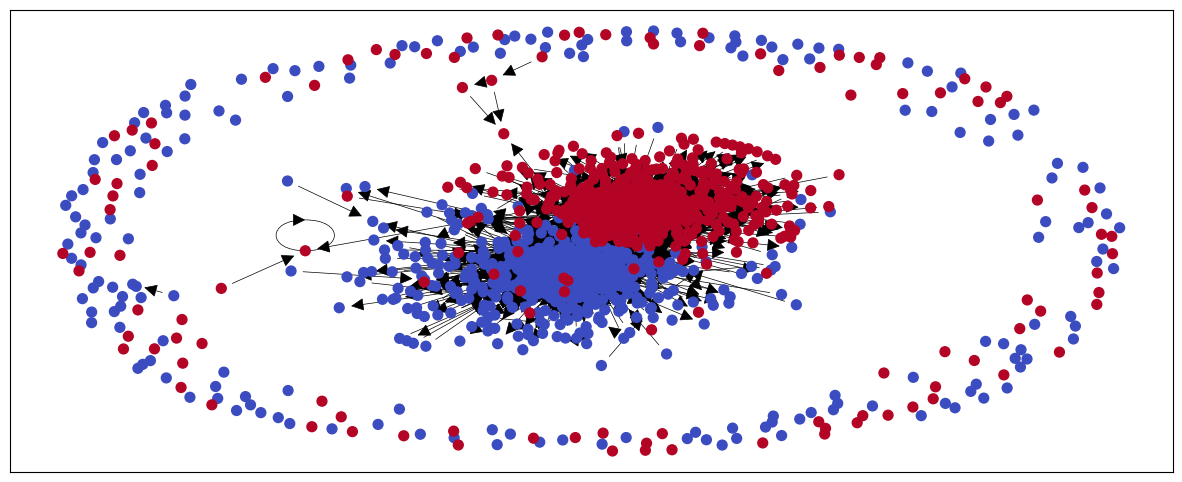

In [ ]:
# Creates a networkx graph using the adjacency matrix of the instantiated graph
G = nx.from_numpy_array(np.array(graph.get_adjacency()))
visualize_graph(G, color=graph.vs['value'])  # Colour liberal blogs blue and conservative blogs red

Displaying only nodes connected to at least one other node, i.e. filtering out isolated nodes

In [ ]:
# Create a copy of the graph
new_graph = graph.copy()

# Find isolated nodes
isolated_nodes = [v.index for v in new_graph.vs if v.degree() == 0]

# Remove isolated nodes
new_graph.delete_vertices(isolated_nodes)

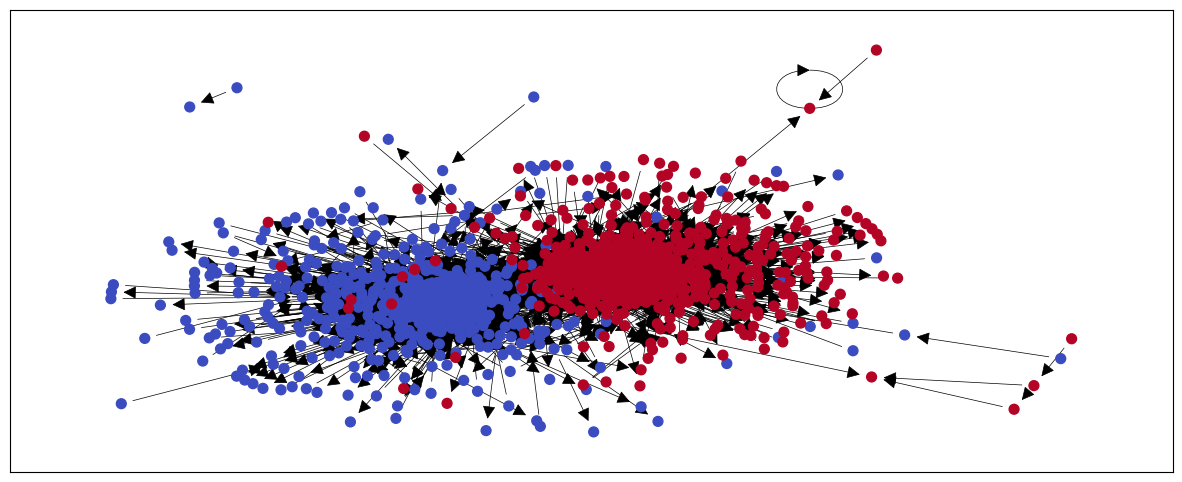

In [ ]:
G_filtered = nx.from_numpy_array(np.array(new_graph.get_adjacency()))

visualize_graph(G_filtered, color=new_graph.vs['value'])

IMPORTANT: only run the next cell if you want to continue considering the graph from which isolated nodes have been removed

In [ ]:
graph = new_graph

**Visualisation of node attributes and data cleaning operations**

In [ ]:
# Get the dataframe containing the node information
df = graph.get_vertex_dataframe()
print(df[:5])

            id                       label  value                    source
vertex ID                                                                  
0          1.0        100monkeystyping.com    0.0                 Blogarama
1          2.0  12thharmonic.com/wordpress    0.0               BlogCatalog
2          5.0       750volts.blogspot.com    0.0                 Blogarama
3          6.0       95theses.blogspot.com    0.0                 Blogarama
4          7.0   abbadabbaduo.blogspot.com    0.0  Blogarama,LeftyDirectory


In [ ]:
# Count the number of samples for each class
class_counts = df.groupby('value').size()
print(class_counts)

value
0.0    588
1.0    636
dtype: int64


In [ ]:
# Check for missing values
missing_values = df.isnull().any()
print(missing_values)

id        False
label     False
value     False
source    False
dtype: bool


In [ ]:
# Check for duplicate nodes
duplicate_rows = df[df.duplicated()]
num_duplicates = df.duplicated().sum()
print(num_duplicates)

0


**Web scraping**

In [ ]:
import requests
from bs4 import BeautifulSoup

counter = 0  # Counter to keep track of the number of unreachable sites

# Function that given a url returns the extracted text content if the blog can be found, otherwise it returns the blog name
def extract_text_from_url(url):
    global counter
    class_names = ["post-body entry-content", "entry-body", "post"]

    try:
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.content, 'html.parser')

        post_body = None
        for class_name in class_names:
            post_body = soup.find(class_=class_name)
            if post_body:
                break

        if post_body:
            text = post_body.get_text().strip()
            return text
        else:
            return url[8:]

    except Exception as e:
        counter += 1
        print(f"Error while extracting text from {url}: {str(e)}")
        return  url[8:]

In [ ]:
# Transforms the domain names of individual blogs, contained in the ‘label’ attribute of each node, into URLs
blog_urls = {node: 'https://' + graph.vs[node]['label'] for node in range(graph.vcount())}

# Extract textual content from each blog
text_data = {node: extract_text_from_url(url) for node, url in blog_urls.items()}

print(f"There were {counter} unreachable websites") # number of unreachable sites

Error while extracting text from https://12thharmonic.com/wordpress: HTTPSConnectionPool(host='12thharmonic.com', port=443): Max retries exceeded with url: /wordpress (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7cb0343d33d0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Error while extracting text from https://4lina.tblog.com: HTTPSConnectionPool(host='4lina.tblog.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7cb0343d3be0>: Failed to resolve '4lina.tblog.com' ([Errno -2] Name or service not known)"))
Error while extracting text from https://ackackack.com: HTTPSConnectionPool(host='ackackack.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)')))
Error while extracting text from https:/

In [ ]:
# Displays the dictionary within which the extracted text for each blog can be found
text_data

{0: '100monkeystyping.com',
 1: '12thharmonic.com/wordpress',
 2: 'Charlie was a mystery.  He didn’t actually live in the house next door, but he was there a lot.  John once told me that the lady who owns the house and Charlie “got a thing going on.” “Me…and…Mrs. Jones…,” He whistled through his missing teeth as he looked at me with a grin.I knew Charlie was a veteran because he usually wore a cap from the Stand-Down, an annual event designed to help homeless veterans get off the street.  Stand-Down was a place to get a haircut, get an ID issued, and find work and possibly even a place to live.  Many veterans have been helped by this program, but too many others appear year after year, never able to keep it together for very long, looking only for a sandwich and an afternoon of hope.Charlie didn’t fit the image of the troubled veteran, and I assumed that he volunteered to help out at the Stand-Down, as many veterans did.  He was always well-kept, healthy, sharp and happy.  He was tall 

**Embedding creation with BERT**

In [ ]:
from transformers import BertTokenizer, BertModel   # Imports the tokenizer and BERT model classes from the Hugging Face transformer library

# Initialises the BERT tokenizer and the pre-trained BERT template on the uncased (case insensitive) version
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_embeddings(text):
    # Transforms input text into tokens, returning PyTorch tensors, with truncation and padding to fit BERT's maximum length
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    # Applies the BERT model on tokenised input
    outputs = model(**inputs)  #  inputs is a dictionary containing the input tensors needed for the BERT model, and **inputs decomposes this dictionary into keys and values
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze()
    return cls_embedding

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Get the embedding for each node and save it in a list
embeddings_list = []  # List containing all embeddings
for node, text in text_data.items():
    embedding = get_embeddings(text).detach()  # Get the PyTorch tensor
    embeddings_list.append(embedding)

# Convert the embedding list into a PyTorch tensor
embeddings = torch.stack(embeddings_list)

In [ ]:
# Save embeddings in a csv file
pd.DataFrame(embeddings).to_csv('polblogs_embeddings.csv', index=False)

In [ ]:
# Upload embeddings from disk
file_name = 'polblogs_embeddings.csv'
embeddings = pd.read_csv(file_name).values

In [ ]:
embeddings.shape

(1490, 768)

IMPORTANT: only run the next cell if you want to filter embeddings representing isolated nodes

In [ ]:
# Remove isolated node embeddings
full_graph = ig.Graph.Read_GML(graph_file)
isolated_nodes = [v.index for v in full_graph.vs if v.degree() == 0]

df = full_graph.get_vertex_dataframe()
embeddings_df = pd.DataFrame(embeddings)
embeddings_filtered = embeddings_df.drop(index=isolated_nodes)
embeddings = embeddings_filtered.to_numpy()

<ipython-input-34-a02bc97d0525>:3: RuntimeWarning: One or more unknown entities will be returned verbatim (&#38;). at src/io/gml.c:150
  full_graph = ig.Graph.Read_GML(graph_file)


In [ ]:
embeddings.shape

(1490, 768)

BERT returns embedding with 768 dimensions

**Reducing the dimensionality of embeddings**

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# PCA instance
pca = PCA()

# Transforms the embedding dataframe into a numpy matrix
feature_matrix = np.array([embeddings[i] for i in range(graph.vcount())])

# Apply PCA
pca.fit(feature_matrix)

# Calculate the cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components expressing 90% of the variance
num_component = np.argmax(cumulative_variance >= 0.90) + 1

In [ ]:
num_component

134

In [ ]:
pca = PCA(n_components=num_component)
# Project the embeddings in a space consisting of as many dimensions as there are principal components expressing 90% of the variance
embeddings_reduced = pca.fit_transform(feature_matrix)

In [ ]:
embeddings_reduced.shape

(1224, 129)

Visualizza la varianza espressa da ciascuna componente

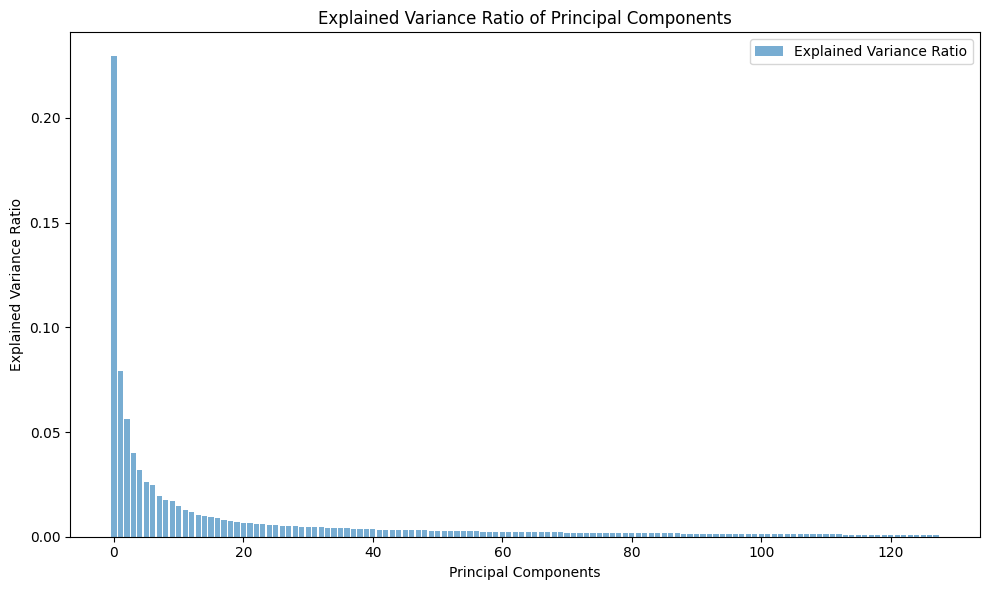

In [ ]:
explained_variance_ratios = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_variance_ratios)), explained_variance_ratios, alpha=0.6, align='center', label='Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**Data object creation and dataset shuffle**.

The layers used to create the model are those provided by the torch_geometric library, which operate on objects of type Data

In [ ]:
from torch_geometric.data import Data
import numpy as np

x_tensor = torch.tensor(embeddings_reduced.astype(np.float32))
edge_index_tensor = torch.tensor(graph.get_edgelist())
y_tensor = torch.tensor(graph.get_vertex_dataframe()['value'])

data = Data(x=x_tensor.float(), edge_index=edge_index_tensor.t(), y=y_tensor)

In [ ]:
data.y

tensor([0., 0., 0.,  ..., 1., 1., 1.], dtype=torch.float64)

I notice that in the dataset there are first all nodes with label 0, then those with label 1

In [ ]:
# Creates a random permutation of indices
torch.manual_seed(42) # import a seed to ensure reproducibility
perm = torch.randperm(data.x.size(0))

# Applies permutation to tensors
x_shuffled = data.x[perm]
y_shuffled = data.y[perm]

# Creates a mapping dictionary from old indices to new ones
index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(perm.tolist())}

# Update edge_index according to new permutation
edge_index_shuffled = torch.clone(data.edge_index)
for i in range(data.edge_index.size(1)):
    edge_index_shuffled[0, i] = index_map[data.edge_index[0, i].item()]
    edge_index_shuffled[1, i] = index_map[data.edge_index[1, i].item()]

data_shuffled = Data(x=x_shuffled, edge_index=edge_index_shuffled, y=y_shuffled.float())

In [ ]:
data_shuffled.y

tensor([0., 0., 1.,  ..., 1., 0., 0.])

Now the data are no longer sorted

**Division of the dataset into training, validation and test set**.

In [ ]:
from sklearn.model_selection import train_test_split

# Extract the number of nodes, node indices and labels
num_nodes = data.num_nodes
indices = torch.arange(num_nodes)
labels = data_shuffled['y']

# Divide the dataset into train (60 per cent), validation (20 per cent) and test (20 per cent) while maintaining the proportions of the classes
train_indices, val_test_indices, train_labels, val_test_labels = train_test_split(indices, labels, test_size=0.4, stratify=labels, random_state=42)
val_indices, test_indices, _, _ = train_test_split(val_test_indices, val_test_labels, test_size=0.5, stratify=val_test_labels, random_state=42)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[val_indices] = True
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[test_indices] = True

data_transformed = data_shuffled
data_transformed.train_mask = train_mask
data_transformed.val_mask = val_mask
data_transformed.test_mask = test_mask

In [ ]:
data_transformed

Data(x=[1224, 128], edge_index=[2, 19090], y=[1224], train_mask=[1224], val_mask=[1224], test_mask=[1224])

# Training

**Initial architecture**

Definition of a simple architecture inspired by the GCN proposed in the paper ‘Semi-Supervised Classification with Graph Convolutional Networks’ written by Thomas N. Kipf and Max Welling in 2017. The main difference lies in the different activation function used for the final layer: whereas Log_Softmax is used in the paper, Sigmoid is adopted in the present model.

In [ ]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv, BatchNorm
import torch.nn.functional as F

class TE_GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.2):
        super(TE_GCN, self).__init__()
        torch.manual_seed(42)

        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout_prob = dropout_prob

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        x = self.conv2(x, edge_index)

        return F.sigmoid(x)

In [ ]:
input_dim = embeddings_reduced.shape[1]  # The input size is equal to the embedding size
hidden_dim = 32  # Hidden layer
output_dim = 1  # Only one output neuron, since the task is of binary classification
dropout_prob = 0.3  # Dropout probability

# Model istance
model = TE_GCN(input_dim, hidden_dim, output_dim, dropout_prob)
print(model)

TE_GCN(
  (conv1): GCNConv(134, 32)
  (conv2): GCNConv(32, 1)
)


In [ ]:
# Move model and tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
    data_transformed.cuda()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Define the functions required for model training and evaluation

In [ ]:
def train_step(model, data, optimizer):
      model.train()
      optimizer.zero_grad()
      out = model(data)
      pred_out = out.squeeze(1)
      loss = criterion(pred_out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss.item()

def val_step(model, data):
    model.eval()
    with torch.no_grad():
      out = model(data)
      pred_out = out.squeeze(1)
      loss = criterion(pred_out[data.val_mask], data.y[data.val_mask])
    return (pred_out, loss.item())

def test(model, data):
    model.eval()
    with torch.no_grad():
      out = model(data)
    return out  # Returns the values of the predictions, without rounding them, to check the confidence with which the model predicts class 0 or class 1

Measure performance on the test set of the untrained model

In [ ]:
from sklearn.metrics import accuracy_score

model.eval()
out = test(model, data_transformed)
# Round up model outputs, converting probabilities to discrete values (0 or 1) to obtain predictions
pred_out = torch.round(out)

if not train_on_gpu:
    print(accuracy_score(data_transformed.y[data_transformed.test_mask], pred_out[data_transformed.test_mask].numpy()))
else:
    # If the model was trained on GPU, I have to move the data structures to CPU since accuracy_score of sklearn works on CPU
    print(accuracy_score(data_transformed.y[data_transformed.test_mask].cpu(), pred_out[data_transformed.test_mask].cpu().numpy()))

0.5503355704697986


Predictably, before training, the model makes random predictions.

Training loop

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.BCELoss()

for epoch in range(1, 201):
    train_loss = train_step(model, data_transformed, optimizer)
    train_losses.append(train_loss)

    val_output, val_loss = val_step(model, data_transformed)
    val_losses.append(val_loss)

    pred = torch.round(val_output)
    val_acc = accuracy_score(data_transformed.y[data_transformed.val_mask].cpu(), pred[data_transformed.val_mask].cpu())
    val_accuracies.append(val_acc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Valdiation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

Epoch: 001, Train Loss: 0.6962, Valdiation Loss: 0.6866, Validation Accuracy: 0.5772
Epoch: 002, Train Loss: 0.7062, Valdiation Loss: 0.6830, Validation Accuracy: 0.5973
Epoch: 003, Train Loss: 0.6997, Valdiation Loss: 0.6795, Validation Accuracy: 0.6007
Epoch: 004, Train Loss: 0.6895, Valdiation Loss: 0.6760, Validation Accuracy: 0.6074
Epoch: 005, Train Loss: 0.6848, Valdiation Loss: 0.6727, Validation Accuracy: 0.6107
Epoch: 006, Train Loss: 0.6814, Valdiation Loss: 0.6694, Validation Accuracy: 0.6174
Epoch: 007, Train Loss: 0.6690, Valdiation Loss: 0.6662, Validation Accuracy: 0.6275
Epoch: 008, Train Loss: 0.6757, Valdiation Loss: 0.6632, Validation Accuracy: 0.6342
Epoch: 009, Train Loss: 0.6695, Valdiation Loss: 0.6602, Validation Accuracy: 0.6577
Epoch: 010, Train Loss: 0.6605, Valdiation Loss: 0.6573, Validation Accuracy: 0.6644
Epoch: 011, Train Loss: 0.6698, Valdiation Loss: 0.6545, Validation Accuracy: 0.6678
Epoch: 012, Train Loss: 0.6633, Valdiation Loss: 0.6517, Validati

Visualization of learning curves

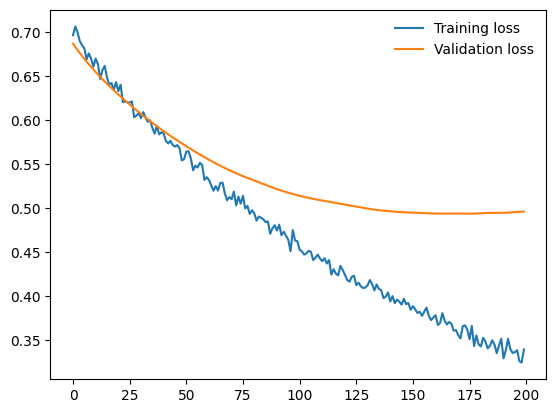

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

Calculates the accuracy on the test set

In [ ]:
model.eval()
out = test(model, data_transformed)
pred_out = torch.round(out)

if not train_on_gpu:
    test_accuracy = accuracy_score(data_transformed.y[data_transformed.test_mask], pred_out[data_transformed.test_mask].numpy())
else:
    test_accuracy = accuracy_score(data_transformed.y[data_transformed.test_mask].cpu(), pred_out[data_transformed.test_mask].cpu().numpy())

print(f'Test Accuracy after 200 epochs: {test_accuracy:.4f}')

Test Accuracy after 200 epochs: 0.7752


**Enhanced version of the initial architecture and train_step**

The number of levels and the number of neurons per level are hyperparameters; therefore, the model is defined parametrically in order to have a flexible architecture regarding the number and size of the network levels.

In [ ]:
from torch.nn import Linear, LayerNorm
from torch_geometric.nn import GCNConv, BatchNorm
import torch.nn.functional as F
import torch.nn.init as init

class TE_GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, linear_dims, output_dim, dropout_prob=0.2):
        super(TE_GCN, self).__init__()
        torch.manual_seed(42)

        self.convs = torch.nn.ModuleList()  # List of convolutional layers
        self.bns_conv = torch.nn.ModuleList() #  List of normalization layers between the convolutional layers

        # Define convolutional layers
        prev_dim = input_dim  # Save in prev_dim the input dimension of the new convolution layer to be instantiated
        for hidden_dim in hidden_dims:
            self.convs.append(GCNConv(prev_dim, hidden_dim))
            self.bns_conv.append(BatchNorm(hidden_dim))
            prev_dim = hidden_dim

        self.linears = torch.nn.ModuleList()  # List of linear layers
        self.bns_linear = torch.nn.ModuleList()  # List of normalization layers between the linear layers

        # Creates linear layers. Now prev_dim represents the input size of the new linear layer to be instantiated
        for linear_dim in linear_dims:
            self.linears.append(Linear(prev_dim, linear_dim))
            self.bns_linear.append(LayerNorm(linear_dim))
            prev_dim = linear_dim

        self.output_layer = Linear(prev_dim, output_dim)  # Define output layer
        self.dropout_prob = dropout_prob

        # Initialise the weights and biases of linear levels with the Xavier normal distribution
        self.initialize_weights()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Instantiates convolution blocks of the type: CONVOLUTION -> NORMALISATION -> ACTIVATION -> DROPOUT
        for conv, bn_conv in zip(self.convs, self.bns_conv):
            x = conv(x, edge_index)
            x = bn_conv(x)  # Compared to the initial model, normalisation is done on the output of the convolution levels
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout_prob, training=self.training)

        # Instantiates linear levels of the type: LINEAR COMBINATION -> NORMALISATION -> ACTIVATION -> DROPOUT
        for linear, bn_linear in zip(self.linears, self.bns_linear):
            x = linear(x)
            x = bn_linear(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout_prob, training=self.training)

        x = self.output_layer(x)
        return torch.sigmoid(x)

    # Function for initialising the weights and biases of linear levels
    def initialize_weights(self):
        for linear in self.linears:
            init.xavier_normal_(linear.weight)
            if linear.bias is not None:
                init.constant_(linear.bias, 0)

        # Initialises the output layer, which is linear
        init.xavier_normal_(self.output_layer.weight)
        if self.output_layer.bias is not None:
            init.constant_(self.output_layer.bias, 0)

Improvement of the training function by adding early stopping to avoid overfitting and AdamW as an optimiser

In [ ]:
import torch.nn as nn
import torch.optim as optim

def train_with_early_stopping(data, input_dim, hidden_dims, linear_dims, output_dim, dropout_prob, learning_rate, weight_decay):
    model = TE_GCN(input_dim, hidden_dims, linear_dims, output_dim, dropout_prob)

    if train_on_gpu:
      model.cuda()

    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')  # Initialisation to infinity of the cost function value on validation data
    best_val_acc = 0  # Initialisation to zero of best accuracy obtained
    patience_counter = 0  # Initialisation to zero of the parameter counting the number of times the loss on the validation set does not improve

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.BCELoss()

    for epoch in range(1, 201):
        train_loss = train_step(model, data, optimizer)
        train_losses.append(train_loss)

        val_output, val_loss = val_step(model, data)
        val_losses.append(val_loss)

        pred = torch.round(val_output)
        val_acc = accuracy_score(data.y[data.val_mask].cpu(), pred[data.val_mask].cpu())
        val_accuracies.append(val_acc)

        if epoch%10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        # Save the new model if it performs better than it did in an earlier era
        if val_acc > best_val_acc:  # best_val_acc contains the accuracy obtained when the model has the best loss value on the validation set
            best_val_loss = val_loss  # best_val_loss contains the lowest value of the cost function on the validation set obtained from the model being trained
            best_val_acc = val_acc
            patience_counter = 0
            best_model = model.state_dict()
        else:
            patience_counter += 1

        # Stop model training if validation loss has not improved for at least 30 epochs
        if patience_counter >= 30:
            print(f'Early stopping at epoch {epoch:03d}')
            break

    return best_val_loss, best_val_acc, train_losses, val_losses, best_model

## Training the new model and validation

In [ ]:
# Definisci gli intervalli degli iperparametri
hidden_dims_list = [[32, 32], [32, 32, 32], [32, 16, 8], [64, 32, 16], [16, 16, 16, 16]]
linear_dims_list = [[16, 8], [8, 4], [4, 2]]
dropout_probs = [0.3, 0.4, 0.5]
learning_rates = [0.001, 0.01]
weight_decays = [1e-3, 1e-4, 1e-5]

In [ ]:
import itertools

# Generates all combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(hidden_dims_list, linear_dims_list, dropout_probs, learning_rates, weight_decays))

In [ ]:
# Itera through all combinations of hyperparameters
best_loss = float('inf')
best_val_acc = 0
best_params = None
best_model_train_losses = []
best_model_val_losses = []

for hidden_dims, linear_dims, dropout_prob, learning_rate, weight_decay in hyperparameter_combinations:
    print(f"\nTraining with: hidden_dims={hidden_dims}, linear_dims={linear_dims}, dropout_prob={dropout_prob}, learning_rate={learning_rate}, weight_decay={weight_decay}")
    val_loss, best_val_acc_model, train_losses, val_losses, best_model = train_with_early_stopping(data_transformed, input_dim, hidden_dims, linear_dims, output_dim, dropout_prob, learning_rate, weight_decay)
    print(f'Validation Loss: {val_loss:.4f}, Best validation accuracy of the model: {best_val_acc_model:.4f}')

    # Save the model that achieved the best accuracy value on the validation set
    if best_val_acc_model > best_val_acc:
        best_loss = val_loss
        best_val_acc = best_val_acc_model
        best_model_train_losses = train_losses
        best_model_val_losses = val_losses
        best_params = (hidden_dims, linear_dims, dropout_prob, learning_rate, weight_decay)
        torch.save(best_model, 'best_model.pth')

print(f'\nBest accuracy: {best_val_acc} with params: hidden_dims={best_params[0]}, linear_dims={best_params[1]}, dropout_prob={best_params[2]}, learning_rate={best_params[3]}, weight_decay={best_params[4]}')


Training with: hidden_dims=[32, 32], linear_dims=[16, 8], dropout_prob=0.3, learning_rate=0.001, weight_decay=0.001
Epoch: 010, Train Loss: 0.7364, Validation Loss: 0.6753, Validation Accuracy: 0.5906
Epoch: 020, Train Loss: 0.7063, Validation Loss: 0.6365, Validation Accuracy: 0.6745
Epoch: 030, Train Loss: 0.6810, Validation Loss: 0.6152, Validation Accuracy: 0.7047
Epoch: 040, Train Loss: 0.6638, Validation Loss: 0.5968, Validation Accuracy: 0.7181
Epoch: 050, Train Loss: 0.6379, Validation Loss: 0.5792, Validation Accuracy: 0.7349
Epoch: 060, Train Loss: 0.6268, Validation Loss: 0.5633, Validation Accuracy: 0.7517
Epoch: 070, Train Loss: 0.5903, Validation Loss: 0.5471, Validation Accuracy: 0.7416
Epoch: 080, Train Loss: 0.5856, Validation Loss: 0.5305, Validation Accuracy: 0.7550
Epoch: 090, Train Loss: 0.5814, Validation Loss: 0.5183, Validation Accuracy: 0.7651
Epoch: 100, Train Loss: 0.5240, Validation Loss: 0.5094, Validation Accuracy: 0.7752
Epoch: 110, Train Loss: 0.5326, V

Upload the best model that was found during validation

In [ ]:
saved_state_dict = torch.load('best_model.pth')

best_model = TE_GCN(input_dim, best_params[0], best_params[1], output_dim)
best_model.load_state_dict(saved_state_dict)

if train_on_gpu:
    best_model.cuda()

In [ ]:
best_model

TE_GCN(
  (convs): ModuleList(
    (0): GCNConv(134, 16)
    (1-3): 3 x GCNConv(16, 16)
  )
  (bns_conv): ModuleList(
    (0-3): 4 x BatchNorm(16)
  )
  (linears): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
  )
  (bns_linear): ModuleList(
    (0): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  )
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
)

Displays the learning curves of the best model obtained during validation

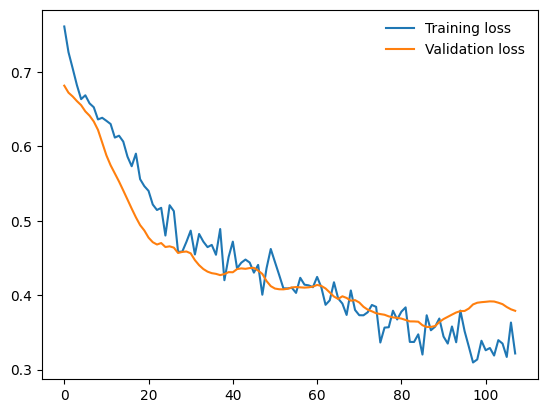

In [ ]:
plt.plot(best_model_train_losses, label='Training loss')
plt.plot(best_model_val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# Performance evaluation on test set

The model is trained and ready for the inference phase

In [ ]:
# Make predictions on test set
best_model.eval()
test_output = test(best_model, data_transformed)
probabilities = torch.cat((1 - test_output, test_output), dim=1)  # Create a tensor of the type ‘Probability class 0, Probability class 1’.
test_pred = torch.round(test_output).int().reshape(-1)  # Round the prediction to determine the predicted class
true_labels = data_transformed.y.int()

# Convert tensors to numpy arrays
test_pred_np = test_pred[data_transformed.test_mask].cpu().numpy()
test_labels_np = true_labels[data_transformed.test_mask].cpu().numpy()

# Get 20 predictions from the test set
some_outputs = probabilities[data_transformed.test_mask][:20]
print("First 20 rows test_output:")
for i, row in enumerate(some_outputs):
    print(f"Percentage for Liberal: {row[0].item():.2f}, Percentage for Conservative: {row[1].item():.2f}, "
          f"Prediction: {test_pred_np[i]}, Target: {test_labels_np[i]}")

First 20 rows test_output:
Percentage for Liberal: 0.05, Percentage for Conservative: 0.95, Prediction: 1, Target: 1
Percentage for Liberal: 0.05, Percentage for Conservative: 0.95, Prediction: 1, Target: 1
Percentage for Liberal: 0.93, Percentage for Conservative: 0.07, Prediction: 0, Target: 0
Percentage for Liberal: 0.85, Percentage for Conservative: 0.15, Prediction: 0, Target: 0
Percentage for Liberal: 0.58, Percentage for Conservative: 0.42, Prediction: 0, Target: 0
Percentage for Liberal: 0.91, Percentage for Conservative: 0.09, Prediction: 0, Target: 0
Percentage for Liberal: 0.05, Percentage for Conservative: 0.95, Prediction: 1, Target: 1
Percentage for Liberal: 0.81, Percentage for Conservative: 0.19, Prediction: 0, Target: 0
Percentage for Liberal: 0.05, Percentage for Conservative: 0.95, Prediction: 1, Target: 1
Percentage for Liberal: 0.05, Percentage for Conservative: 0.95, Prediction: 1, Target: 1
Percentage for Liberal: 0.88, Percentage for Conservative: 0.12, Predicti


Test set Accuracy: 0.8255

Test set Classification Report:

               precision    recall  f1-score   support

           0       0.81      0.86      0.83       152
           1       0.85      0.79      0.82       146

    accuracy                           0.83       298
   macro avg       0.83      0.82      0.82       298
weighted avg       0.83      0.83      0.83       298



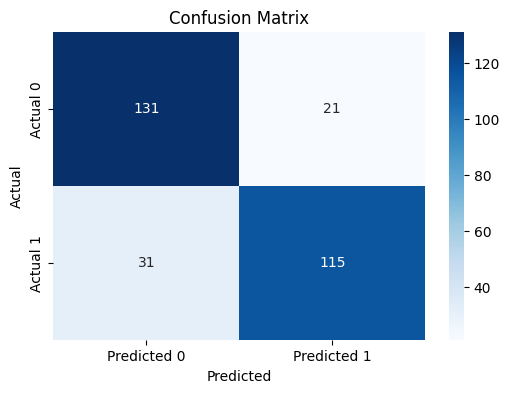

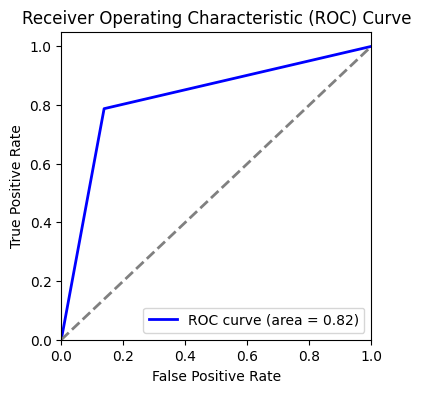

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate classification metrics
test_accuracy = accuracy_score(test_labels_np, test_pred_np)
test_classification_report = classification_report(test_labels_np, test_pred_np)
print(f'\nTest set Accuracy: {test_accuracy:.4f}')
print(f'\nTest set Classification Report:\n\n {test_classification_report}')

test_confusion_matrix = confusion_matrix(test_labels_np, test_pred_np)
fpr, tpr, thresholds = roc_curve(test_labels_np, test_pred_np)
roc_auc = roc_auc_score(test_labels_np, test_pred_np)  # Compute Area Under ROC Curve (AUC)

# Confusion matrix visualization
plt.figure(figsize=(6, 4))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# View ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()